# FashionReviewer Python Code

## By Jingting Zhang, Oct 8, 2018

In [45]:
# Load Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import tensorflow

%matplotlib inline
import nltk
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.tokenize import RegexpTokenizer
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import re
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN

import os

### and so on

## Data Import & Visualization

In [47]:
path = "/Users/jingtingzhang/Documents/Insight2018_2/scripts/Womens Clothing E-Commerce Reviews.csv"
df = pd.read_csv(path)
df.head(10)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
7,7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits
8,8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
Unnamed: 0                 23486 non-null int64
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


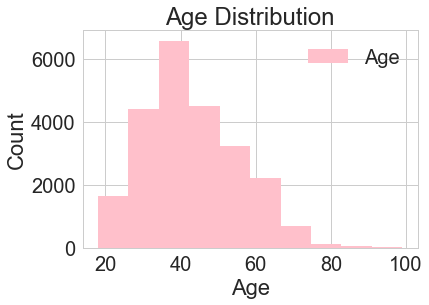

In [49]:
# The age distribution in data
plt.hist(df["Age"], color="pink", label = "Age")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.savefig("Age Distribution.png")

# remove frame from plt

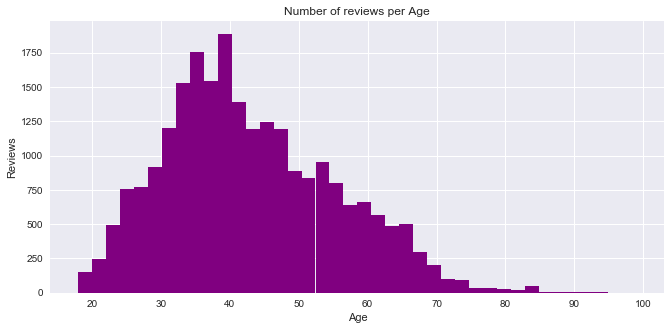

In [50]:
sns.set(rc = {"figure.figsize":(11,5)})
plt.hist(df.Age, bins = 40,  color="purple")
plt.xlabel("Age")
plt.ylabel("Reviews")
plt.title("Number of reviews per Age");
plt.savefig("Number of reviews per Age.png")

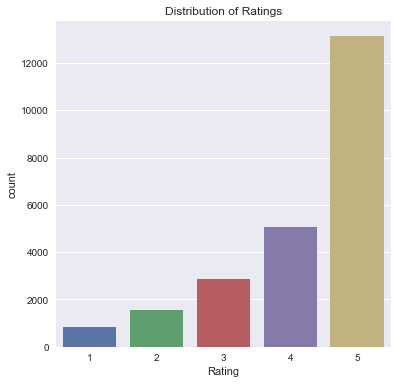

In [51]:
sns.set(rc = {"figure.figsize":(6,6)})
plt.title("Distribution of Ratings")
sns.countplot(x = "Rating", data = df);
plt.savefig("Distribution of Ratings.png")

In [52]:
recommended = df[df["Recommended IND"]==1]
not_recommended = df[df["Recommended IND"]==0]

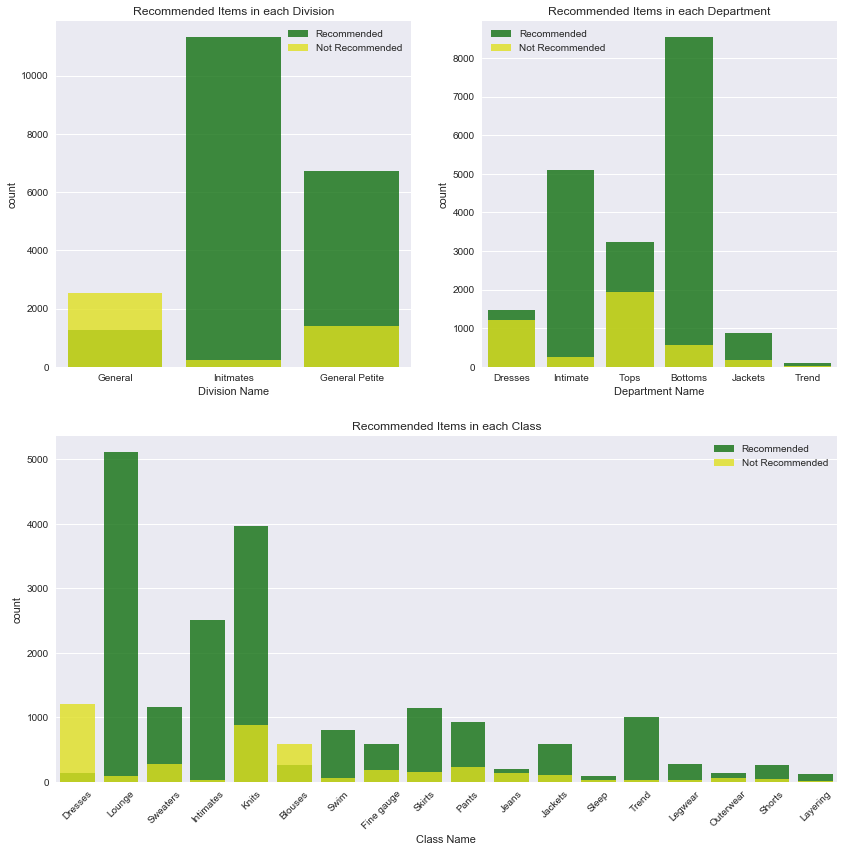

In [11]:
fig = plt.figure(figsize=(14, 14))
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1 = sns.countplot(recommended['Division Name'], color = "green", alpha = 0.8, label = "Recommended")
ax1 = sns.countplot(not_recommended['Division Name'], color = "yellow", alpha = 0.8, label = "Not Recommended")
ax1 = plt.title("Recommended Items in each Division")
ax1 = plt.legend()

ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2 = sns.countplot(recommended['Department Name'], color="green", alpha = 0.8, label = "Recommended")
ax2 = sns.countplot(not_recommended['Department Name'], color="yellow", alpha = 0.8, label = "Not Recommended")
ax2 = plt.title("Recommended Items in each Department")
ax2 = plt.legend()

ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax3 = plt.xticks(rotation=45)
ax3 = sns.countplot(recommended['Class Name'], color="green", alpha = 0.8, label = "Recommended")
ax3 = sns.countplot(not_recommended['Class Name'], color="yellow", alpha = 0.8, label = "Not Recommended")
ax3 = plt.title("Recommended Items in each Class")
ax3 = plt.legend()
plt.savefig("Recommended Items in each Division or Class.png")

In [53]:
df["Review Length"] = df["Review Text"].astype(str).apply(len)
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Length
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,53
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,303
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,500
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,124
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,192


/Users/jingtingzhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


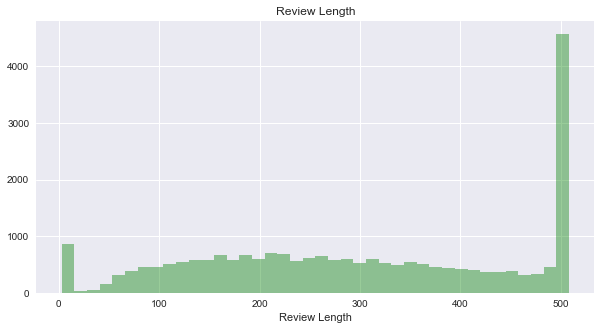

In [54]:
fig = plt.figure(figsize=(10, 5))
ax = sns.distplot(df["Review Length"], color="green", bins=40, kde=False)
ax = plt.title("Review Length")
plt.savefig("Review Length.png")

In [56]:
df["Review Length"] = df["Review Text"].astype(str).apply(len)
#df.head()

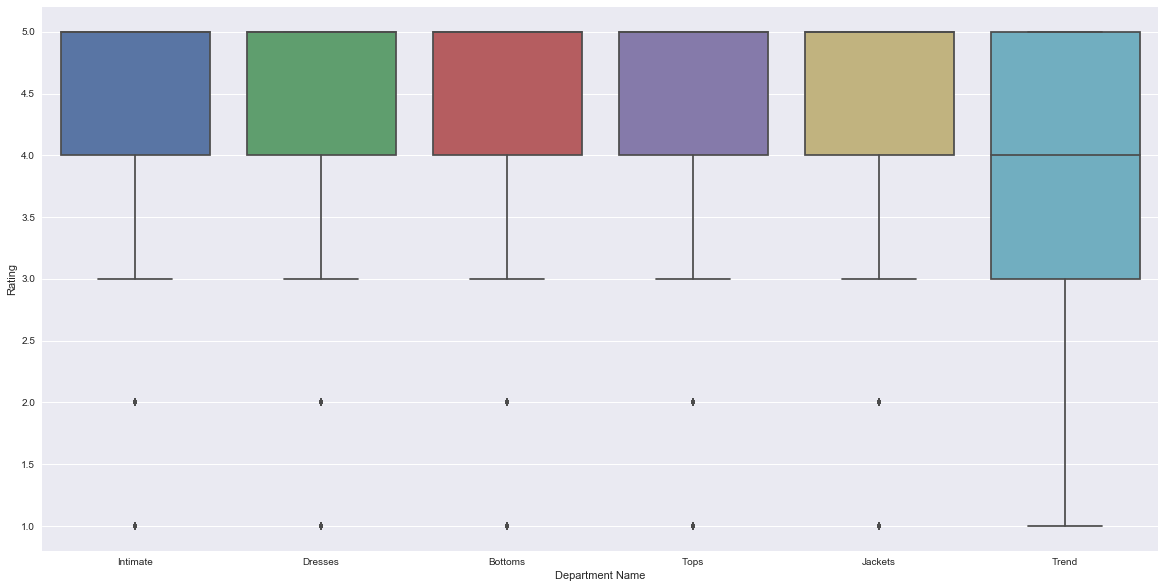

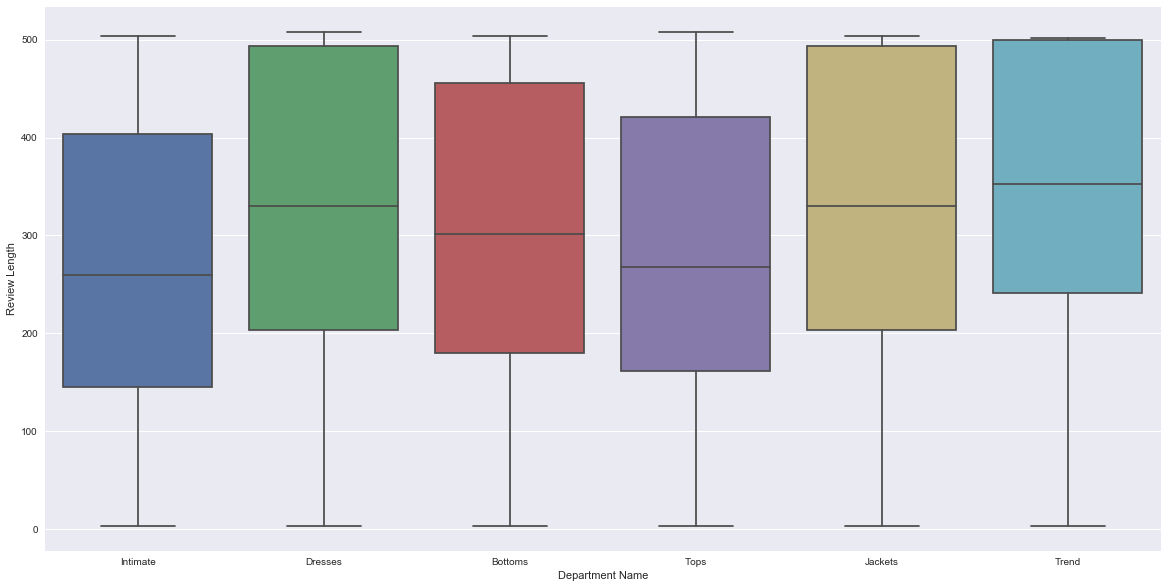

In [58]:
plt.figure(figsize=(20,10))
sns.boxplot(x = "Department Name", y = "Rating", data = df)
plt.figure(figsize=(20,10))
sns.boxplot(x = "Department Name", y = "Review Length", data = df)

In [57]:
sns.set(rc={figure.figsize=(20,10)})
plt.title("Review Length by Class")
sns.boxplot(x = "Class Name", y = "Review Length", data = df);
plt.savefig("Review Length by Class.png")

SyntaxError: invalid syntax (<ipython-input-57-aa90e60a02ed>, line 1)

In [59]:
ps = PorterStemmer()
Reviews = df['Review Text'].astype(str)
print(Reviews.shape)
Reviews[Reviews.isnull()] = "NULL"

(23486,)


## Keyword detection

### Pre-processing: tokenize, remove keywords, lemmatize

In [ ]:
#import sys
#!{sys.executable} -m pip install summa

In [ ]:
# import spacy

# nlp = spacy.load('')
# doc = nlp(u"Autonomous cars shift insurance liability toward manufacturers")
# for token in doc:
#     print(token.text, token.dep_, token.head.text, token.head.pos_,
#           [child for child in token.children])

In [60]:
tokenizer = RegexpTokenizer(r'[a-zA-Z]{3,}')

In [61]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jingtingzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
!{sys.executable} -m pip install gensim

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [63]:
import gensim
from gensim.summarization import graph
from gensim.summarization import keywords

In [64]:
# The txt file should not contain quotes or paragraph separating functions (soft cap would work) #
with open('review_text_4.txt', 'r') as tfile:
    txt = tfile.read()

In [65]:
import sys
!conda install --yes --prefix {sys.prefix} gensim

Solving environment: done

# All requested packages already installed.



In [66]:
plt.figure(figsize=(20,10))
sns.boxplot(txt, scores, data = df)

NameError: name 'scores' is not defined

<Figure size 1440x720 with 0 Axes>

In [67]:
def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ')
    words = tokenizer.tokenize(txt) 
    words = [w for w in words if not w in stop_words]
    return words

In [68]:
df['tokenized']=df["Review Text"].astype(str).str.lower() # Turn into lower case text
df['tokenized']=df.apply(lambda row: tokenizer.tokenize(row['tokenized']), axis=1) # Apply tokenize to each row
df['tokenized']=df['tokenized'].apply(lambda x: [w for w in x if not w in stop_words]) # Remove stopwords from each row

In [70]:
def string_unlist(strlist):
    return " ".join(strlist)

df["tokenized_unlist"] = df["tokenized"].apply(string_unlist)
#df.head()

In [74]:
print(gensim.summarization.keywords(words, ratio=0.2, words=None, split=True, scores=True, 
                                       pos_filter=('NN', 'JJ'), lemmatize=True, deacc=True))

NameError: name 'words' is not defined

In [73]:
print(gensim.summarization.keywords(txt, ratio=0.2, words=None, split=True, scores=True, 
                                       pos_filter=('NN', 'JJ'), lemmatize=True, deacc=True))

[('looked', 0.2869922368916953), ('loving', 0.22600395359028225), ('dresse', 0.21471457955425044), ('coloring', 0.19501906195274338), ('fitted', 0.19305192984028222), ('likes', 0.19244724807478109), ('littl', 0.16141161464387666), ('great', 0.15644247659220042), ('sizes', 0.1439227715185717), ('fabrication', 0.14115896829069818), ('perfects', 0.10828156496732164), ('beauties', 0.10232187215727204), ('cuteness', 0.09969939784825826), ('retailers', 0.09724148008717645), ('prettiness', 0.09699366414568825), ('wearings', 0.09655078267470917), ('styles', 0.09519113693400558), ('softness', 0.09493009506955859), ('sweaters', 0.09406488882903162), ('feelings', 0.08869109000741986), ('shirts', 0.0882445477746434), ('materi', 0.08584560640504489), ('black', 0.08583575507404968), ('designer', 0.07992118979601892), ('smalls', 0.07972250802700885), ('bits', 0.0781287407567483), ('pant', 0.07805221935785306), ('comfortably', 0.07578584338706237), ('skirted', 0.07558132909029405), ('shortness', 0.074

## Word2Vec

In [75]:
model_location = '/Users/jingtingzhang/Documents/Insight2018_2/scripts/'
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit = 1000000)

In [76]:
w1="size"
model.wv.most_similar(positive=w1)

/Users/jingtingzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


[('sized', 0.6793718934059143),
 ('Size', 0.6218184232711792),
 ('sizes', 0.6117527484893799),
 ('4_chars', 0.5373417735099792),
 ('height', 0.528750479221344),
 ('width', 0.5177116394042969),
 ('larger', 0.5073246955871582),
 ('small', 0.496220201253891),
 ('smaller', 0.49511170387268066),
 ('girth', 0.49143078923225403)]

In [ ]:
# # for sentence in review:
# #     word=sentence.split(' ')
#     for word in sentences:
#         word2vec = Word2Vec(sentences=review,
#                     size=vector_size, 
#                     window=window_size, 
#                     negative=20,
#                     iter=50,
#                     seed=1000)  
# #         print(word)
# word2vec.save(model_location + 'word2vec.model')

In [77]:
w2="color"
model.wv.most_similar(positive=w2)

/Users/jingtingzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


[('colors', 0.6966161131858826),
 ('Color', 0.6928340792655945),
 ('vibrant_colors', 0.6224876046180725),
 ('hues', 0.613426148891449),
 ('color_palette', 0.6065829992294312),
 ('colored', 0.5960179567337036),
 ('skintone', 0.5772755742073059),
 ('Colour', 0.5770692825317383),
 ('reds_greens', 0.5723066329956055),
 ('bright_colors', 0.5709342956542969)]

In [78]:
import multiprocessing
from scipy import spatial

In [79]:
index2word_set = set(model.wv.index2word)

def avg_feature_vector(sentence, model, num_features, index2word_set):
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

/Users/jingtingzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [80]:
sim_size=[]
w1="size"
w1_afv = avg_feature_vector(w1, model=model, num_features=300, index2word_set=index2word_set)
for sentence in df['tokenized_unlist']:
    sentence_afv = avg_feature_vector(sentence, model=model, num_features=300, index2word_set=index2word_set)
    sim_size.append(1 - spatial.distance.cosine(sentence_afv, w1_afv)) 
df['sim_size']=pd.Series(sim_size)
print(df['sim_size'])

0        0.128292
1        0.343448
2        0.502368
3        0.152768
4        0.245637
5        0.369772
6        0.364145
7        0.401852
8        0.427592
9        0.417269
10       0.330217
11       0.221054
12       0.297173
13       0.356436
14       0.587446
15       0.412468
16       0.500779
17       0.273112
18       0.270927
19       0.320272
20       0.392885
21       0.408740
22       0.332469
23       0.398852
24       0.246015
25       0.390827
26       0.381579
27       0.343771
28       0.151329
29       0.341943
           ...   
23456    0.285270
23457    0.287747
23458    0.203342
23459    0.409819
23460    0.334439
23461    0.375842
23462    0.300047
23463    0.417554
23464    0.294014
23465    0.284313
23466    0.310716
23467    0.454514
23468    0.384914
23469    0.564453
23470    0.027628
23471    0.274244
23472    0.247393
23473    0.368170
23474    0.308946
23475    0.330754
23476    0.314566
23477    0.424118
23478    0.264588
23479    0.356463
23480    0

In [81]:
sim_color=[]
w2="color"
w2_afv = avg_feature_vector(w2, model=model, num_features=300, index2word_set=index2word_set)
for sentence in df['tokenized_unlist']:
    sentence_afv = avg_feature_vector(sentence, model=model, num_features=300, index2word_set=index2word_set)
    sim_color.append(1 - spatial.distance.cosine(sentence_afv, w2_afv)) 
df['sim_color']=pd.Series(sim_color)
print(df.sim_color)

0        0.287109
1        0.277545
2        0.328593
3        0.305439
4        0.364290
5        0.427708
6        0.431552
7        0.461118
8        0.386699
9        0.353988
10       0.305851
11       0.334203
12       0.404584
13       0.327311
14       0.353804
15       0.348991
16       0.362369
17       0.383756
18       0.297999
19       0.361951
20       0.303153
21       0.400794
22       0.286500
23       0.349854
24       0.365069
25       0.304109
26       0.378608
27       0.522996
28       0.240646
29       0.431454
           ...   
23456    0.327734
23457    0.348564
23458    0.346779
23459    0.352636
23460    0.335671
23461    0.373819
23462    0.382194
23463    0.295928
23464    0.461235
23465    0.299242
23466    0.250146
23467    0.429142
23468    0.369243
23469    0.414229
23470    0.033588
23471    0.332909
23472    0.388096
23473    0.297951
23474    0.422599
23475    0.352857
23476    0.331078
23477    0.509661
23478    0.332380
23479    0.453556
23480    0

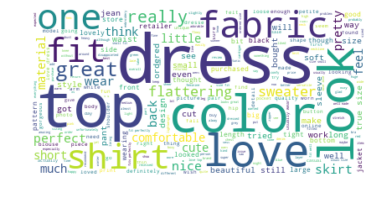

In [82]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_words=400, background_color="white").generate(txt)
# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
# plt.show()
plt.savefig("plot_wordcloud_keywords.png")

In [83]:
from __future__ import absolute_import, division, print_function
import numpy as np
count = len(df)
word_vectors_matrix = np.ndarray(shape=(count, 300), dtype='float64')
word_list = []
i = 0
for word in model.vocab:
    word_vectors_matrix[i] = model[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

word_vectors_matrix shape is  (23486, 300)


In [84]:
#Compress word vectors into 2D space
import sklearn.decomposition
pca= sklearn.decomposition.PCA(n_components=2, random_state=0)
word_vectors_matrix_2d = pca.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

word_vectors_matrix_2d shape is  (23486, 2)


In [85]:
for i in df.index:
    if  -0.05 < (sim_size[i]-sim_color[i]) < 0.05:
        df.loc[i, "clothingfeature"] = "both"
    elif (sim_size[i]-sim_color[i]) > 0.05:
        df.loc[i, "clothingfeature"] = "size"
    else:
        df.loc[i, "clothingfeature"] = “color”

In [86]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jingtingzhang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [88]:
# Pre-Processing
SIA = SentimentIntensityAnalyzer()

# Applying Model, Variable Creation
df["Polarity Score"] = df["tokenized_unlist"].apply(lambda x:SIA.polarity_scores(x)["compound"])
df["Neutral Score"] = df["tokenized_unlist"].apply(lambda x:SIA.polarity_scores(x)["neu"])
df["Negative Score"] = df["tokenized_unlist"].apply(lambda x:SIA.polarity_scores(x)["neg"])
df["Positive Score"] = df["tokenized_unlist"].apply(lambda x:SIA.polarity_scores(x)["pos"])

# Converting 0 to 1 Decimal Score to a Categorical Variable
df["Sentiment"] = ''
df.loc[df["Polarity Score"] > 0,'Sentiment'] = "Positive"
df.loc[df["Polarity Score"] == 0,'Sentiment'] = "Neutral"
df.loc[df["Polarity Score"] < 0,'Sentiment'] = "Negative"

In [90]:
conditions = [
    df["Sentiment"] == "Positive",
    df["Sentiment"] == "Negative",
    df["Sentiment"] == "Neutral"]
choices = [1,-1,0]
df["label"] = np.select(conditions, choices)
pd.set_option("display.max_columns", 100)
#df.head()

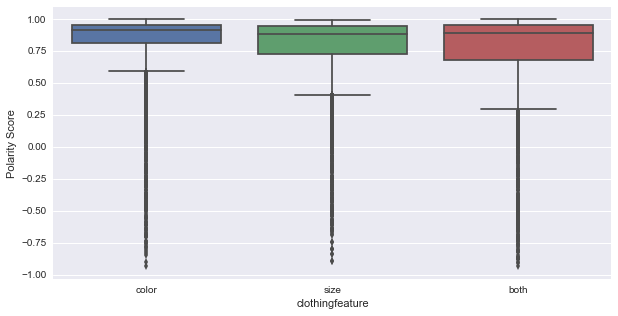

In [91]:
plt.figure(figsize=(10,5))
sns.boxplot(x = "clothingfeature", y = "Polarity Score", data = df)

In [92]:
df_color = df[df.loc[:, "clothingfeature"]=="color"]

In [93]:
df_size = df[df.loc[:, "clothingfeature"]=="size"]

In [94]:
############ Train df_color ###############
samples = df_color["tokenized_unlist"].tolist()
maxlen = 100 
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))
data = pad_sequences(sequences, maxlen = maxlen)

Found 8535 unique tokens.


In [95]:
labels = np.asarray(df_color["label"].values)
print("Shape of data tensor:", data.shape)
print("Shape of label tensor:", labels.shape)

Shape of data tensor: (8389, 100)
Shape of label tensor: (8389,)


In [96]:
indices = np.arange(df_color.shape[0])
np.random.shuffle(indices)
print(indices)

[7309  341 7361 ... 1698 3067   19]


In [97]:
data = data[indices]
labels = labels[indices]
print(data)

[[   0    0    0 ...   37  212   27]
 [   0    0    0 ...  116  228   11]
 [   0    0    0 ... 2587   20  130]
 ...
 [   0    0    0 ...   12  909  910]
 [   0    0    0 ...   55  679  699]
 [   0    0    0 ...   50   57   13]]


In [98]:
training_samples = 5871
validation_samples = 8807 #2936
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: validation_samples] 
y_val = labels[training_samples: validation_samples]
x_test = data[validation_samples:]
y_test = labels[validation_samples:]
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)
#return x_train

In [99]:
def build_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(64, activation = "relu"))
    model.add(Dense(32, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(optimizer = "rmsprop",
              loss = "binary_crossentropy",
              metrics = ["acc"])
    return model

model = build_model()
model.summary()
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=40,
                    validation_data=(x_val, y_val))

model.save("model1.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,642,177
Trainable params: 1,642,177
Non-trainable params: 0
_________________________________________________________________
Train on 5871 samples, validate on 2518 samples
Epoch 1/5
5871/5871 [==============================] - 2s 283us/step - loss: 0.1830 

In [100]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

In [101]:
model.evaluate(x_test, y_test)

[]

### RNN Model for Size

In [102]:
######################## RNN ########################
def build_RNN():
    model = Sequential() 
    model.add(Embedding(max_words, 100, input_length = maxlen)) 
    #model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32)) 
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["acc"]) 
    return model

model = build_RNN()
model.summary()
history_RNN = model.fit(x_train, y_train,
                    epochs = 5,
                    batch_size = 40,
                    validation_data = (x_val, y_val))

model.save("model_RNN.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                4256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,004,289
Trainable params: 1,004,289
Non-trainable params: 0
_________________________________________________________________
Train on 5871 samples, validate on 2518 samples
Epoch 1/5
5871/5871 [==============================] - 5s 870us/step - loss: 0.2082 - acc: 0.9653 - val_loss: 0.1784 - val_acc: 0.9754
Epoch 2/5
5871/5871 [==============================] - 5s 797us/step - loss: 0.1434 - acc: 0.9739 - val_loss: 0.1404 - val_acc: 0.9742
Epoch 3/5
5871/5871 [==============================] - 4s 747us/step - loss: 0

In [103]:
acc = history_RNN.history["acc"]
val_acc = history_RNN.history["val_acc"]
loss = history_RNN.history["loss"]
val_loss = history_RNN.history["val_loss"]
epochs = range(1, len(acc) + 1)

In [104]:
model.evaluate(x_test, y_test)

[]

In [105]:
############ Classify Sentiment for the Size Clothing Feature ###############
samples = df_size["tokenized_unlist"].tolist()
maxlen = 100 
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))
data = pad_sequences(sequences, maxlen = maxlen)

Found 6737 unique tokens.


In [106]:
labels = np.asarray(df_size["label"].values)
print("Shape of data tensor:", data.shape)
print("Shape of label tensor:", labels.shape)

Shape of data tensor: (5862, 100)
Shape of label tensor: (5862,)


In [107]:
indices = np.arange(df_size.shape[0])
np.random.shuffle(indices)
print(indices)

[3632 4694 5082 ... 5537 4946 2962]


In [108]:
data = data[indices]
labels = labels[indices]
print(data)

[[   0    0    0 ...  431   45    1]
 [   0    0    0 ...   40 1078 1484]
 [   0    0    0 ...   63   98  233]
 ...
 [   0    0    0 ...   97  395    1]
 [   0    0    0 ...  131  656 6312]
 [   0    0    0 ...  912 1319 1912]]


In [109]:
training_samples = 5871
validation_samples = 8807
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: validation_samples] 
y_val = labels[training_samples: validation_samples]
x_test = data[validation_samples:]
y_test = labels[validation_samples:]
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)
#return x_train

In [110]:
def build_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(64, activation = "relu"))
    model.add(Dense(32, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(optimizer = "rmsprop",
              loss = "binary_crossentropy",
              metrics = ["acc"])
    return model

model = build_model()
model.summary()
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=40,
                    validation_data=(x_val, y_val))

model.save("model1.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,642,177
Trainable params: 1,642,177
Non-trainable params: 0
_________________________________________________________________
Train on 5862 samples, validate on 0 samples
Epoch 1/5
5862/5862 [==============================] - 2s 294us/step - loss: 0.2659 - a

In [111]:
model = build_model()
model.summary()
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=40,
                    validation_data=(x_val, y_val))

model.save("model1.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 1,642,177
Trainable params: 1,642,177
Non-trainable params: 0
_________________________________________________________________
Train on 5862 samples, validate on 0 samples
Epoch 1/5
5862/5862 [==============================] - 2s 285us/step - loss: 0.2708 - a

In [112]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

KeyError: 'val_acc'

In [113]:
acc = history_RNN.history["acc"]
val_acc = history_RNN.history["val_acc"]
loss = history_RNN.history["loss"]
val_loss = history_RNN.history["val_loss"]
epochs = range(1, len(acc) + 1)

In [114]:
model.evaluate(x_test, y_test)

[]

### RNN Model for Size

In [115]:
######################## RNN ########################
def build_RNN():
    model = Sequential() 
    model.add(Embedding(max_words, 100, input_length = maxlen)) 
    #model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32)) 
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["acc"]) 
    return model

model = build_RNN()
model.summary()
history_RNN = model.fit(x_train, y_train,
                    epochs = 5,
                    batch_size = 40,
                    validation_data = (x_val, y_val))

model.save("model_RNN.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                4256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,004,289
Trainable params: 1,004,289
Non-trainable params: 0
_________________________________________________________________
Train on 5862 samples, validate on 0 samples
Epoch 1/5
5862/5862 [==============================] - 5s 825us/step - loss: 0.3029 - acc: 0.9451
Epoch 2/5
5862/5862 [==============================] - 4s 708us/step - loss: 0.2358 - acc: 0.9533
Epoch 3/5
5862/5862 [==============================] - 4s 731us/step - loss: 0.1012 - acc: 0.9498
Epoch 4/5
5862/5862 [==============================] - 4s

In [119]:
acc = history_RNN.history["acc"]
val_acc = history_RNN.history["val_acc"]
loss = history_RNN.history["loss"]
val_loss = history_RNN.history["val_loss"]
epochs = range(1, len(acc) + 1)

In [120]:
model.evaluate(x_test, y_test)

[]

### END